In [ ]:
# ==============================================
# 1. SETUP & INSTALLATION
# ==============================================
# !pip install torch torchvision tqdm matplotlib --quiet

# ==============================================
# 2. IMPORT LIBRARIES
# ==============================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==============================================
# 3. DATA PREPARATION
# ==============================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x * 2) - 1)  # Scale to [-1, 1]
])

train_dataset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True)

# ==============================================
# 4. BUILD THE DIFFUSION MODEL
# ==============================================

# Simple U-Net style model for diffusion
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x, t):
        t_emb = t[:, None, None, None]
        t_emb = t_emb.expand(x.size(0), 1, x.size(2), x.size(3))
        t_emb = t_emb.to(x.device)  # <-- FIX: move t_emb to same device as x
        x = torch.cat([x, t_emb], dim=1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x


model = SimpleUNet().to(device)

# Diffusion hyperparameters
T = 300  # Total noise steps
beta = torch.linspace(1e-4, 0.02, T, device=device)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0).to(device)

# Helper functions
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bar[t])[:, None, None, None]
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise, noise

# ==============================================
# 5. TRAINING LOOP
# ==============================================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    pbar = tqdm(train_loader)
    loss_epoch = 0
    for images, _ in pbar:
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),)).long()
        x_t, noise = add_noise(images, t)

        noise_pred = model(x_t, t / T)
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

        pbar.set_description(f"Epoch {epoch+1} Loss {loss_epoch/len(train_loader):.4f}")

Using device: cuda


Epoch 10 Loss 0.0904: 100%|██████████| 469/469 [00:13<00:00, 35.34it/s]


Sampling: 300it [00:05, 57.02it/s]


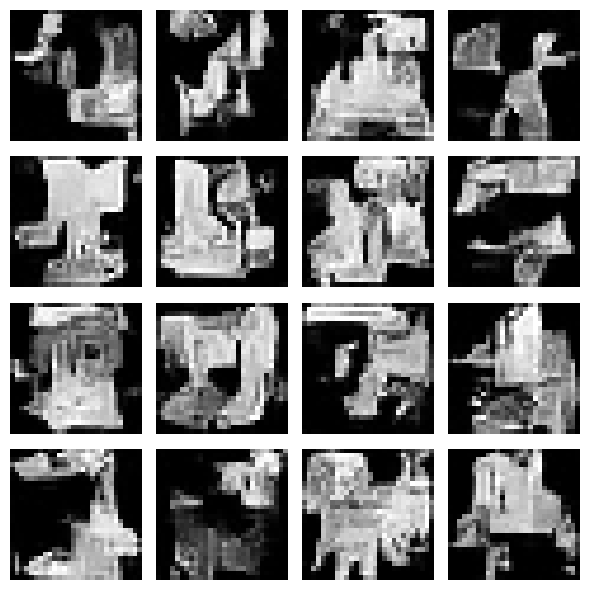

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 233MB/s] 


FID Score Approximate: 179.62
✅ Training Complete!
✅ Samples Generated!
✅ FID Evaluation Done!


In [ ]:
# ==============================================
# 6. SAMPLING AND VISUALIZING GENERATED IMAGES
# ==============================================

@torch.no_grad()
def sample_images(model, n_samples=500):
    model.eval()
    x = torch.randn((n_samples, 1, 28, 28), device=device)
    for i in tqdm(reversed(range(T)), desc="Sampling"):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        z = torch.randn_like(x) if i > 0 else 0
        alpha_t = alpha[t][:, None, None, None]
        alpha_bar_t = alpha_bar[t][:, None, None, None]
        beta_t = beta[t][:, None, None, None]
        eps_theta = model(x, t / T)
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * eps_theta) + torch.sqrt(beta_t) * z
    x = torch.clamp((x + 1) / 2, 0, 1)
    return x

# Sample more images (for FID)
generated_images = sample_images(model, n_samples=500)

# Visualize a few of the generated images (only 16)
fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i in range(16):
    img = generated_images[i]
    axs[i//4, i%4].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[i//4, i%4].axis('off')
plt.tight_layout()
plt.show()

# ==============================================
# 7. EVALUATION - FID Score (Approximate)
# ==============================================

from torchvision.models import inception_v3
from scipy.linalg import sqrtm

# Feature extractor
inception = inception_v3(pretrained=True, transform_input=False).to(device)
inception.fc = nn.Identity()

# Helper to extract features
def get_activations(dataloader, model, n_samples=1000):
    model.eval()
    act = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = F.interpolate(x, size=(299, 299), mode='bilinear')
            x = x.repeat(1, 3, 1, 1)  # Fake RGB
            x = x.to(device)
            pred = model(x)
            act.append(pred.cpu().numpy())
            if len(act) * x.size(0) >= n_samples:
                break
    act = np.concatenate(act, axis=0)
    return act.reshape(act.shape[0], -1)

# Real activations
real_acts = get_activations(train_loader, inception, n_samples=500)

# Generated activations
@torch.no_grad()
def get_generated_activations(generated_images, model):
    model.eval()
    imgs = generated_images
    imgs = (imgs - 0.5) * 2  # Rescale [-1, 1]
    imgs = F.interpolate(imgs, size=(299, 299), mode='bilinear')
    imgs = imgs.repeat(1, 3, 1, 1)  # 1 channel to 3 channel
    preds = model(imgs.to(device))
    acts = preds.cpu().numpy()
    return acts.reshape(acts.shape[0], -1)

gen_acts = get_generated_activations(generated_images, inception)

# Compute FID
def calculate_fid(act1, act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

fid = calculate_fid(real_acts, gen_acts)

print(f"FID Score Approximate: {fid:.2f}")

# ==============================================
# 8. FINAL NOTES
# ==============================================

print("✅ Training Complete!")
print("✅ Samples Generated!")
print("✅ FID Evaluation Done!")


In [ ]:
# ==============================================
# Save Model - All Professional Options
# ==============================================

import torch

# 1. Save only the model weights (recommended)
torch.save(model.state_dict(), "ddpm_fashionmnist_weights.pth")
print("✅ Model weights saved as 'ddpm_fashionmnist_weights.pth'")

# 2. Save full training checkpoint (model + optimizer + epoch + loss + settings)
checkpoint = {
    'epoch': epoch if 'epoch' in locals() else 'N/A',  # Save epoch if available
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict() if 'optimizer' in locals() else 'N/A',
    'loss': loss.item() if 'loss' in locals() else 'N/A',
    'T': T  # Save diffusion steps if needed
}
torch.save(checkpoint, "ddpm_fashionmnist_full_checkpoint.pth")
print("✅ Full training checkpoint saved as 'ddpm_fashionmnist_full_checkpoint.pth'")

# 3. Save the full model (architecture + weights) [Not recommended usually]
torch.save(model, "ddpm_fashionmnist_full_model.pth")
print("✅ Full model (structure + weights) saved as 'ddpm_fashionmnist_full_model.pth'")


✅ Model weights saved as 'ddpm_fashionmnist_weights.pth'
✅ Full training checkpoint saved as 'ddpm_fashionmnist_full_checkpoint.pth'
✅ Full model (structure + weights) saved as 'ddpm_fashionmnist_full_model.pth'
